In [2]:
import psycopg2
import os
from dotenv import load_dotenv

# Loads all the variables in .env to here
load_dotenv()

# Gets all the information from .env
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')

# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT,
)

# Creates a cursor
cur = conn.cursor()

print("Connected to PostgreSQL!")


Connected to PostgreSQL!


In [3]:
cur.execute("SELECT * FROM train_bank_dataset;")

rows = cur.fetchall()
column_names = [desc[0] for desc in cur.description]


In [4]:
import pandas as pd
df = pd.DataFrame(rows, columns=column_names)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.utils import resample

In [6]:
df.head()

,age,job,marital,education,is_default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,"""management""","""married""","""tertiary""","""no""",2143,"""yes""","""no""","""unknown""",5,"""may""",261,1,-1,0,"""unknown""","""no"""
1,44,"""technician""","""single""","""secondary""","""no""",29,"""yes""","""no""","""unknown""",5,"""may""",151,1,-1,0,"""unknown""","""no"""
2,33,"""entrepreneur""","""married""","""secondary""","""no""",2,"""yes""","""yes""","""unknown""",5,"""may""",76,1,-1,0,"""unknown""","""no"""
3,47,"""blue-collar""","""married""","""unknown""","""no""",1506,"""yes""","""no""","""unknown""",5,"""may""",92,1,-1,0,"""unknown""","""no"""
4,33,"""unknown""","""single""","""unknown""","""no""",1,"""no""","""no""","""unknown""",5,"""may""",198,1,-1,0,"""unknown""","""no"""


In [7]:
categorical_features = ['job', 'marital', 'education', 'is_default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

le = LabelEncoder()
for col in categorical_features:
    df[col] = le.fit_transform(df[col])

In [8]:
df['engagement_score'] = df['campaign'] + df['previous']
df['financial_stability'] = df['balance'] - (df['loan'] + df['housing'] + df['is_default'])
df['recency_score'] = np.where(df['pdays'] == -1, 0, 1 / (df['pdays'] + 1))
df['churn'] = np.where((df['y'] == 0) & (df['pdays'] > 30), 1, 0)


In [9]:
seed = 69


C:\Users\steve\AppData\Local\Temp\ipykernel_11876\2731667606.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['churn'], palette='coolwarm')


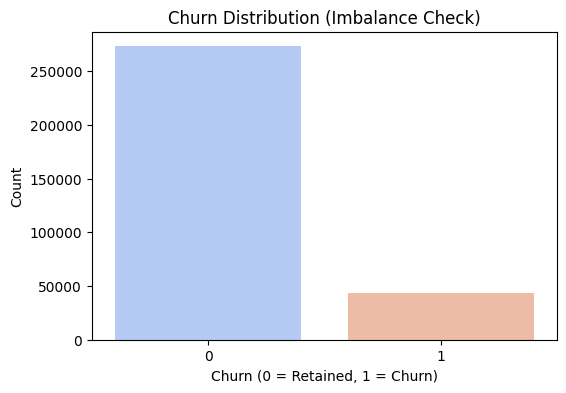

Churn Distribution:
churn
0    0.863042
1    0.136958
Name: proportion, dtype: float64


In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['churn'], palette='coolwarm')
plt.title("Churn Distribution (Imbalance Check)")
plt.xlabel("Churn (0 = Retained, 1 = Churn)")
plt.ylabel("Count")
plt.show()

churn_distribution = df['churn'].value_counts(normalize=True)
print("Churn Distribution:")
print(churn_distribution)

In [11]:
X = df[['age', 'balance', 'campaign', 'previous', 'engagement_score', 'financial_stability', 'recency_score']]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Handle Imbalance using Random Oversampling
train_data = pd.concat([X_train, y_train], axis=1)
majority_class = train_data[train_data['churn'] == 0]
minority_class = train_data[train_data['churn'] == 1]

minority_upsampled = resample(minority_class, 
                              replace=True,  # Duplicate samples
                              n_samples=len(majority_class), 
                              random_state=seed)
train_resampled = pd.concat([majority_class, minority_upsampled])
X_train_resampled = train_resampled.drop('churn', axis=1)
y_train_resampled = train_resampled['churn']

In [12]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, max_depth = 10, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=seed)
model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=69)

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [14]:
print("Classification Report: ")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score: ", roc_auc_score(y_test, y_prob))

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     54671
           1       0.77      1.00      0.87      8625

    accuracy                           0.96     63296
   macro avg       0.89      0.98      0.92     63296
weighted avg       0.97      0.96      0.96     63296

ROC-AUC Score:  0.9915861961101176


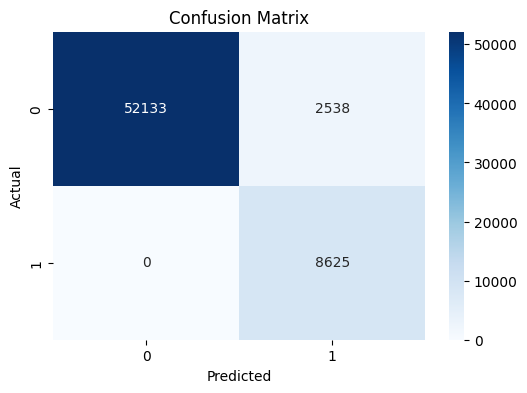

In [15]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

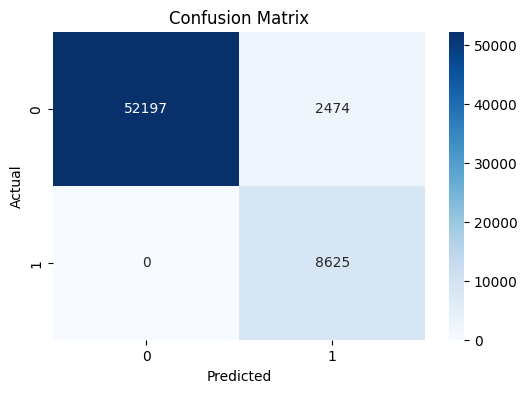

In [21]:
threshold = 0.65
y_pred_adjusted = (y_prob > threshold).astype(int)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
conn.close()
cur.close()
